In [49]:
import pandas
import pyreadr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import cross_val_predict


# Instructions
You will need to download the following files from the Allen Brain MULTIPLE CORTICAL AREAS - SMART-SEQ (2019) dataset: https://portal.brain-map.org/atlases-and-data/rnaseq/human-multiple-cortical-areas-smart-seq. 
* trimmed_means.csv
* matrix.csv
* metadata.csv

Keep track of where you put the data. You might move it to `data/` for simplicity

#### Developmental cell analysis
To perform 

# Load and harmonize data

In [2]:
# change these to your preferred directories
figdir = './figures/'
ctdir = './data/'

In [3]:
df = pandas.read_csv('data/trimmed_means.csv', index_col=0)
df.head()

,Exc L5-6 FEZF2 ANKRD20A1,Exc L5-6 THEMIS TMEM233,Inh L1 LAMP5 NDNF,Exc L6 FEZF2 CPZ,Astro L1 FGFR3 MT1G,Exc L2-3 LINC00507 RPL9P17,Exc L6 FEZF2 KRT17,Exc L3-4 RORB FOLH1B,Endo L2-5 CLDN5,Exc L5-6 RORB LINC00320,...,Exc L4 RORB CACNG5,Exc L6 FEZF2 FAM95C,Inh L1-3 VIP GGH,Exc L3-5 FEZF2 DCN,Exc L6 FEZF2 ETV4,Exc L5-6 FEZF2 RSAD2,Inh L1 ADARB2 DISP2,Inh L5-6 LAMP5 SFTA3,Exc L6 FEZF2 TBC1D26,Inh L4-5 PVALB TRIM67
feature,,,,,,,,,,,,,,,,,,,,,
3.8-1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.8-1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.8-1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.8-1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-HT3C2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# This was created in Notebook 3: PLS_ModelExploration
comps = pandas.read_csv('data/all_comps.csv')
comps.index = comps.gene_symbol.values
comps.head()

,Unnamed: 0,C1,gene_symbol,gene_name,C2,C3,C1_genelist,C2_genelist,C3_genelist
A1BG,0,0.001956,A1BG,alpha-1-B glycoprotein,0.003711,-0.021865,0.0,0.0,1.0
A1BG-AS1,1,-0.007211,A1BG-AS1,NaN,-0.007837,-0.003920,0.0,0.0,0.0
A2M,2,0.005342,A2M,alpha-2-macroglobulin,0.008298,0.001742,0.0,0.0,0.0
A2ML1,3,-0.007153,A2ML1,alpha-2-macroglobulin-like 1,-0.004419,-0.006947,0.0,0.0,0.0
A3GALT2,4,-0.002024,A3GALT2,NaN,0.001295,0.002109,0.0,0.0,0.0


In [5]:
# find common genes across datasets
shared = sorted(list(set(comps.index) & set(df.index)))

In [6]:
# harmonize indices
comps = comps.loc[shared]
df = df.loc[shared]

# Single cell analysis

#### Load the data

In [7]:
meta = pandas.read_csv('./data/metadata.csv')
meta.columns

Index(['sample_name', 'exp_component_name', 'specimen_type', 'cluster_color',
       'cluster_order', 'cluster_label', 'class_color', 'class_order',
       'class_label', 'subclass_color', 'subclass_order', 'subclass_label',
       'full_genotype_color', 'full_genotype_order', 'full_genotype_label',
       'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color',
       'region_order', 'region_label', 'cortical_layer_color',
       'cortical_layer_order', 'cortical_layer_label',
       'cell_type_accession_color', 'cell_type_accession_order',
       'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_order',
       'cell_type_alias_label', 'cell_type_alt_alias_color',
       'cell_type_alt_alias_order', 'cell_type_alt_alias_label',
       'cell_type_designation_color', 'cell_type_designation_order',
       'cell_type_designation_label', 'external_donor_name_color',
       'external_donor_name_order', 'external_donor_name_label',
       'outlier_call', 'outli

In [8]:
# cell phenotypic data of interest
cues = ['cluster_label','class_label','subclass_label','region_label',
       'cortical_layer_label','cell_type_alias_label']

In [9]:
meta.region_label.value_counts()

MTG     16155
V1C      8052
A1C      6703
CgG      6279
M1lm     3371
S1ul     3188
M1ul     2864
S1lm     2805
Name: region_label, dtype: int64

The following section is important for the purposes of reproducibility. The data matrix here takes a really long time to load, so I end up saving a compressed version of it for easier/faster re-runs in the future. Saving only the values (e.g. no string labels) makes loading this data much faster. However, that means we need to make sure we have the correct labels for this matrix. The `shared` variable (which serves as the index) is of type `set`, and the order of elements seems to vary from run to run. Therefore, I convert it to a sorted list and I seperately save the index labels. Your first time generating this data, this should not be a problem, but if you wish to rerun it, make sure you save and load both the matrix and the labels.

#### If running for the first time, run these cells (if not, skip them!)

In [10]:
# load the single cell matrix. This is an enormous spreadsheet so may take a very long time to load
# could potentially crash your computer/python if enough memory isn't available
mtx = pandas.read_csv('./data/matrix.csv')

In [11]:
# harmonize genes
mtx = mtx[shared]

In [12]:
# saving a smaller, easier to load version of the matrix for future runs:
np.savez_compressed('./data/fullmtx.npz',mtx.values)

In [13]:
# saving the genes or else they will get shuffled around
np.savez_compressed('./data/matrix_genes.npz',mtx.columns.values)

#### Run the following cells only if this is not the first time you're running this notebook

In [10]:
# load cell x gene matrix
mtx = np.load('./data/fullmtx.npz')['arr_0']

In [11]:
# load gene labels
shared = np.load('./data/matrix_genes.npz',allow_pickle=True)['arr_0']

In [12]:
mtx = pandas.DataFrame(mtx,columns=shared)

#### Get component expression of each cell
Here, we are using the weights from the PLS model to discover the relative expression of each latent Tx component in each cell. For various reasons, it is hard to interpret the resulting values as absolute values, but the relative values across subtypes are meaningful, as they (may) represent cell-specific differences in representation of each of the latent variables

In [13]:
cells = pandas.DataFrame(index=meta.index)
for i in range(1,4):
    print('working on component',i)
    cells.loc[:,'C%s'%i] = np.dot(mtx,comps.loc[shared,'C%s'%i].values)

working on component 1
working on component 2
working on component 3


In [14]:
# populate dataframe with cell phenotypes
for cue in cues:
    cells.loc[:,cue] = meta[cue].values

#### Null model

I don't think this next analysis is altogether necessary, but doing it in case a reviewer asks. Here, for each individual cell, we are seeing whether the component expression of each cell is greater than would be expected by chance given the data. In other words, is component expression greater within-cell than would be expected by random weight vector. Whether cell-specific expression is "significant" isn't necessarily important as much as whether cell-specific expression differs across cell classes/types. But nonetheless a significance test may be informative so here we go.

I did a kind of "quick" version of this null model that we can politely call an "optimization". Rather than doing a null model for each individual cell, we're selecting a random cell for each iteration, and calculating expression of a randomized weight vector within that cell. By concatenating the expression values across all iterations, we can have a null distribution of that component composed of 10k (or `n_iter`) random examples. It's not perfect but it's quick and probably sufficient

In [15]:
n_iter = 10000 # number of iterations 
prng = np.random.RandomState(123) # set random_state
# catch the results
nulls = pandas.DataFrame(index=range(n_iter),columns = ['C1','C2','C3']) 
# for each component
for c in range(1,4):
    print('Working on component',c)
    # get the true weight vector
    vec = np.array(comps.loc[shared,'C%s'%c].values)
    # for each iteration
    for i in range(n_iter):
        if i % 1000 == 0: print('iteration %s of %s'%((i+1),n_iter))
        # select a random cell
        x = mtx.loc[prng.choice(mtx.index)]
        # produce a shuffled weight vector
        prng.shuffle(vec)
        # find the null expression level and store it
        nulls.loc[i,'C%s'%c] = np.dot(x,vec)
        
    

Working on component 1
iteration 1 of 10000
iteration 1001 of 10000
iteration 2001 of 10000
iteration 3001 of 10000
iteration 4001 of 10000
iteration 5001 of 10000
iteration 6001 of 10000
iteration 7001 of 10000
iteration 8001 of 10000
iteration 9001 of 10000
Working on component 2
iteration 1 of 10000
iteration 1001 of 10000
iteration 2001 of 10000
iteration 3001 of 10000
iteration 4001 of 10000
iteration 5001 of 10000
iteration 6001 of 10000
iteration 7001 of 10000
iteration 8001 of 10000
iteration 9001 of 10000
Working on component 3
iteration 1 of 10000
iteration 1001 of 10000
iteration 2001 of 10000
iteration 3001 of 10000
iteration 4001 of 10000
iteration 5001 of 10000
iteration 6001 of 10000
iteration 7001 of 10000
iteration 8001 of 10000
iteration 9001 of 10000


In [16]:
# preload the null distributions
distrs = {}
for c in nulls.columns:
    distrs.update({c: np.array(sorted(nulls[c].values))})

# generate p-values for each cell based on the null distributions
count = 0
for i,row in cells.iterrows():
    if count % 1000 == 0: print('working on %s of %s'%((count+1),len(cells)))
    for c in cells.columns[:3]:
        if row[c] < 0:
            p = len(distrs[c][distrs[c]<row[c]]) / n_iter
        else:
            p = len(distrs[c][distrs[c]>row[c]]) / n_iter
        cells.loc[i,'p_%s'%c] = p
    count+=1

working on 1 of 49417
working on 1001 of 49417
working on 2001 of 49417
working on 3001 of 49417
working on 4001 of 49417
working on 5001 of 49417
working on 6001 of 49417
working on 7001 of 49417
working on 8001 of 49417
working on 9001 of 49417
working on 10001 of 49417
working on 11001 of 49417
working on 12001 of 49417
working on 13001 of 49417
working on 14001 of 49417
working on 15001 of 49417
working on 16001 of 49417
working on 17001 of 49417
working on 18001 of 49417
working on 19001 of 49417
working on 20001 of 49417
working on 21001 of 49417
working on 22001 of 49417
working on 23001 of 49417
working on 24001 of 49417
working on 25001 of 49417
working on 26001 of 49417
working on 27001 of 49417
working on 28001 of 49417
working on 29001 of 49417
working on 30001 of 49417
working on 31001 of 49417
working on 32001 of 49417
working on 33001 of 49417
working on 34001 of 49417
working on 35001 of 49417
working on 36001 of 49417
working on 37001 of 49417
working on 38001 of 49417

In [17]:
# find the proportion of each cell class that exhibit greater than chance
# expression of each component
for pcol in ['p_C1','p_C2','p_C3']:
    # here we're using an alpha value of 0.025 to account for the two-tailed 
    # nature of the association 
    print(pcol,'\n',cells[cells[pcol]<0.025].class_label.value_counts() /\
                    cells.class_label.value_counts(),'\n\n')

p_C1 
 Glutamatergic    0.971693
GABAergic        0.923930
Non-neuronal     0.271197
Name: class_label, dtype: float64 


p_C2 
 Glutamatergic    0.977105
GABAergic        0.596070
Non-neuronal     0.002314
Name: class_label, dtype: float64 


p_C3 
 Glutamatergic    0.059176
GABAergic        0.019825
Non-neuronal     0.011361
Name: class_label, dtype: float64 




# Expression differences across cell phenotypes

#### Cell class

In [18]:
# since this is just pattern expression (the absolute values aren't meaningful)
# we'll zscore the expression values
from sklearn.preprocessing import StandardScaler
for col in ['C1','C2','C3']:
    cells.loc[:,'z%s'%col] = StandardScaler().fit_transform(cells[col].values.reshape(-1,1))[:,0]

In [19]:
# prep for plots
cells.loc[:,'ind'] = range(len(cells))
tall = cells.melt(id_vars='ind',value_vars = ['zC1','zC2','zC3'],var_name='component',value_name = 'expr')
for col in ['class_label','region_label','subclass_label']:
    tall.loc[:,col] = cells[col].tolist() * 3

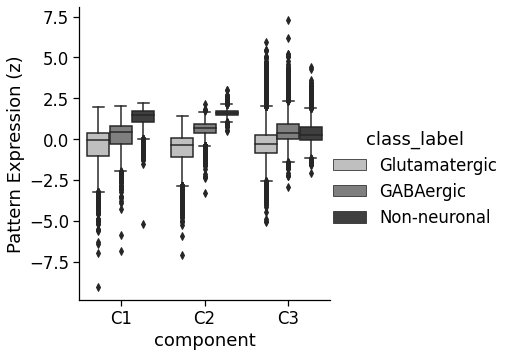

In [20]:
# Here, we will plot expression differences across cell classes for each component
sns.set_context('notebook',font_scale=1.5)
g=sns.catplot(x='component',y='expr',hue='class_label',data=tall,kind='box',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal'],
             palette='binary')
g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
# plt.savefig(os.path.join(figdir,'cellclass.pdf'),bbox_inches='tight')

This plot suggests remarkable difference in expression across cell types. C2, for example can differentiate cell classes incredibly well. Rather than test this with a regular statistical test like an anova or something, these look so qualitatively different that we could probably do out-of-sample classification with a cross-validated logistic regression. This is approach would be more robust, more conservative, and will provide more interpretable information about differences (e.g. how well can gradient expression alone predict cell class).

In [42]:
# initiate logistic regression model (will be automatically multiclass)
lr = LogisticRegressionCV(random_state=123,)
# set X to gradient expression and y to cell class
y = cells['class_label'].dropna()
X = cells.loc[y.index,['zC1','zC2','zC3']]
# use cross-validation to make out of sample predictions and concatenate them
pred = cross_val_predict(lr,X,y,groups=y)

# display classification performance metrics
print(classification_report(y,pred))
print('accuracy:', accuracy_score(y,pred))
print('balanced accuracy:',balanced_accuracy_score(y,pred))


               precision    recall  f1-score   support

    GABAergic       0.91      0.92      0.91     11450
Glutamatergic       0.98      0.97      0.97     31229
 Non-neuronal       0.96      0.96      0.96      4753

     accuracy                           0.96     47432
    macro avg       0.95      0.95      0.95     47432
 weighted avg       0.96      0.96      0.96     47432

accuracy: 0.9572862202732333
balanced accuracy: 0.9502170747342781


These results again suggest remarkable difference in gradient expression across cell types. This is quite surprising. This suggests at least two possibilities. The first is that, besides reflecting (and perhaps driving) spatial organization of the brain at the mesoscale, the molecular gradient may also reflect (or drive) cell-type differentiation / fate / lineage at the microscale. The secound possibility is that the molecular gradients are actually reflecting differences in cell-type proportion throughout the brain, which is itself a spatially distributed organizing principle. 

The second hypothesis can be addressed by examining whether cell type proportion varies across brain regions and, if it does, whether it does so in a regional pattern consistent the regional gradient pattern. Here we will investigate this idea.

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


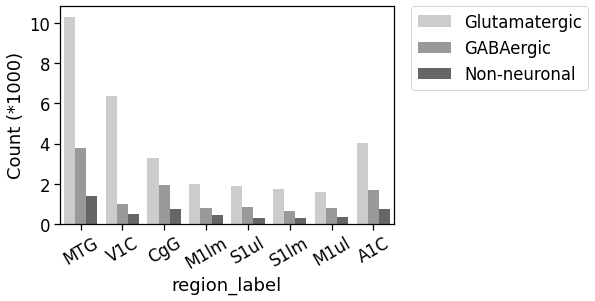

In [21]:
# let's get a look at total cell count of each class across each region
palette=sns.color_palette('binary',4)[:3]
sns.set_context('notebook',font_scale=1.5)
g=sns.countplot(x='region_label',hue='class_label',data=cells,
              hue_order=['Glutamatergic','GABAergic','Non-neuronal'],
             palette=sns.color_palette('binary',4)[:3])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
g.set_ylabel('Count (*1000)')
g.set_yticklabels([0,2,4,6,8,10])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig(os.path.join(figdir,'cell_counts.pdf'),bbox_inches='tight')

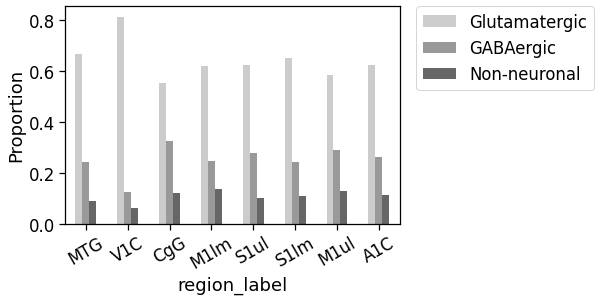

In [36]:
# And now we'll do the same thing but represent it as a proportion.
order = ['MTG','V1C','CgG','M1lm','S1ul','S1lm','M1ul','A1C']
oorder = ['Glutamatergic','GABAergic','Non-neuronal']
g=pandas.crosstab(index=cells.region_label,columns=cells.class_label,normalize='index'
               ).loc[order,oorder].plot.bar(color=sns.color_palette('binary',4)[:3])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
g.set_ylabel('Proportion')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig(os.path.join(figdir,'cell_prop.pdf'),bbox_inches='tight')


There seems to be some variation across regions, but it's not very substantial. The sensorimotor, auditory cortex and (surprisingly) MTG are quite similar; meanwhile the cingulate seems to have slightly more GABAergic cells and the visual cortex far more glutamatergic and less GABAergic. Perhaps a case could be made for decreasing excitatory and increaseing inhibitory neurons as one move anteriorly across the brain, similar to the spatial pattern of C2? However, these differences likely are not even statistically different. Let's test it

In [37]:
# This is a few functions to run a nice Chi2 test with multiple comparisons that I found on
# stack overflow awhile ago and use for various purposes.

def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text


def chisq_and_posthoc_corrected(df,always_posthoc=True):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = stats.chi2_contingency(df, correction=True)
    print("Chi2 result of the contingency table: %s, p-value: %s"%(chi2,p))
    
    if always_posthoc or p<0.05:
    # post-hoc
        all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
        p_vals = []
        print("Significance results:")
        for comb in all_combinations:
            new_df = df[(df.index == comb[0]) | (df.index == comb[1])]+1
            chi2, p, dof, ex = stats.chi2_contingency(new_df, correction=True)
            p_vals.append(p)
            # print(f"For {comb}: {p}")  # uncorrected

        # checking significance
        # correction for multiple testing
        reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
        for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
            print("%s: p_value: %5f; corrected: %5f (%s) reject: %s"%(comb,
                                                                      p_val,
                                                                      corr_p_val,
                                                                      get_asterisks_for_pval(p_val),
                                                                      reject))

In [38]:
jnk = pandas.crosstab(index=cells.region_label,columns=cells.class_label,normalize='index'
               ).loc[order,oorder]
chisq_and_posthoc_corrected(jnk)

Chi2 result of the contingency table: 0.19483152175756235, p-value: 0.9999999999848301
Significance results:
('MTG', 'V1C'): p_value: 0.993761; corrected: 0.999896 (ns) reject: False
('MTG', 'CgG'): p_value: 0.996504; corrected: 0.999896 (ns) reject: False
('MTG', 'M1lm'): p_value: 0.999261; corrected: 0.999896 (ns) reject: False
('MTG', 'S1ul'): p_value: 0.999487; corrected: 0.999896 (ns) reject: False
('MTG', 'S1lm'): p_value: 0.999878; corrected: 0.999896 (ns) reject: False
('MTG', 'M1ul'): p_value: 0.998284; corrected: 0.999896 (ns) reject: False
('MTG', 'A1C'): p_value: 0.999555; corrected: 0.999896 (ns) reject: False
('V1C', 'CgG'): p_value: 0.981149; corrected: 0.999896 (ns) reject: False
('V1C', 'M1lm'): p_value: 0.990508; corrected: 0.999896 (ns) reject: False
('V1C', 'S1ul'): p_value: 0.989705; corrected: 0.999896 (ns) reject: False
('V1C', 'S1lm'): p_value: 0.992857; corrected: 0.999896 (ns) reject: False
('V1C', 'M1ul'): p_value: 0.985934; corrected: 0.999896 (ns) reject: F

In [39]:
jnk = pandas.crosstab(index=cells.region_label,columns=cells.class_label,normalize='index'
               ).loc[order,oorder]
chisq_and_posthoc_corrected(jnk.T)

Chi2 result of the contingency table: 0.19483152175756235, p-value: 0.9999999999848301
Significance results:
('Glutamatergic', 'GABAergic'): p_value: 1.000000; corrected: 1.000000 (ns) reject: False
('Glutamatergic', 'Non-neuronal'): p_value: 1.000000; corrected: 1.000000 (ns) reject: False
('GABAergic', 'Non-neuronal'): p_value: 1.000000; corrected: 1.000000 (ns) reject: False


No significant differences, whether looking at cell class distribution across regions or regional distribution across cell classes. This seems to do at least some work to dispel the notion that the gradients themselves are driven entirely by cell class proportion

Another way we could look at this is just the overall expression of each component across cell types. This is a bit harder to interpret because it's hard to know what "more" gradient expression means, and gradient expression is two-tailed. However, we can qualitatively (or quantitatively if a reviewer insists) examine the relative expression of each component across regions.

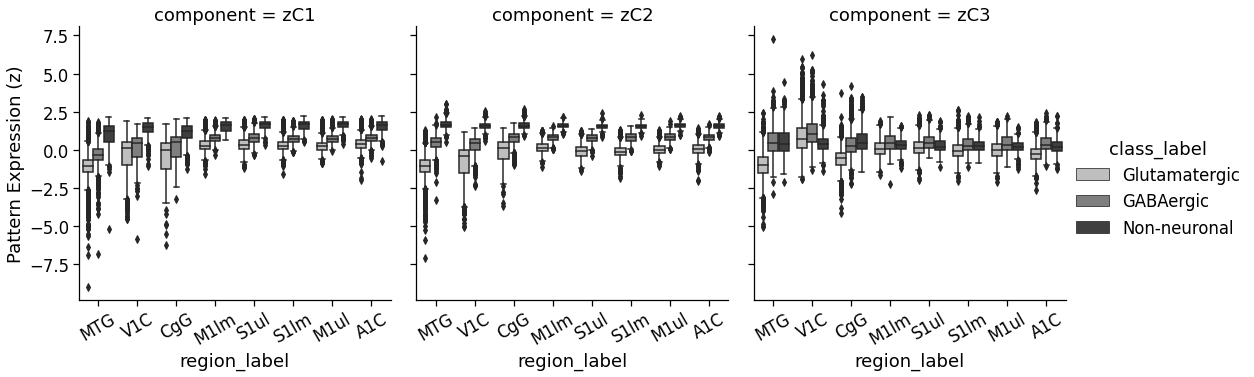

In [43]:
g = sns.catplot(x='region_label',y='expr',hue='class_label',col='component',data=tall,kind='box',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal'],palette='binary')
g.set_xticklabels(rotation=30)
#g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
# plt.savefig(os.path.join(figdir,cellclassXregion.pdf'),bbox_inches='tight')

The relative expression of each component seems fairly conserved across region and, while there is variation in differentiation magnitude across regions, the relative positions of each cell class is highly similar across regions within components. 

We can look at a similar question simply using mean expression of each cell class across all genes, and see if that differs across regions.

In [47]:
cells.loc[:,'mean_expr'] = pandas.DataFrame(mtx).T.mean()

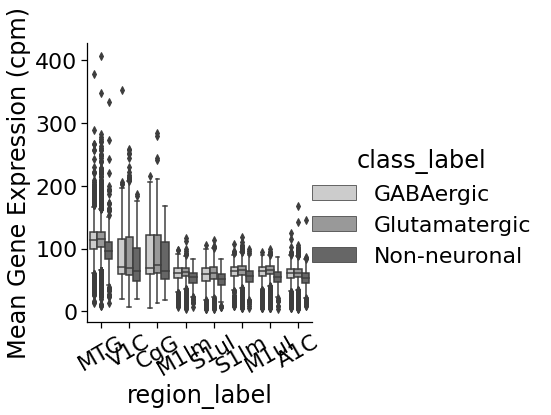

In [48]:
sns.set_context('notebook',2)
g = sns.catplot(x='region_label',y='mean_expr',hue='class_label',data=cells,kind='box',
           palette=sns.color_palette('binary',4)[:3])
g.set_xticklabels(rotation=30)
#g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Mean Gene Expression (cpm)')
#plt.savefig(os.path.join(figdir,'regional_cpm.pdf'),bbox_inches='tight')

#### Cell subclass
So there are pretty substantial differences in spatial gradient expression across major cell classes, but what about across subclasses within the major classes? Let's have a look

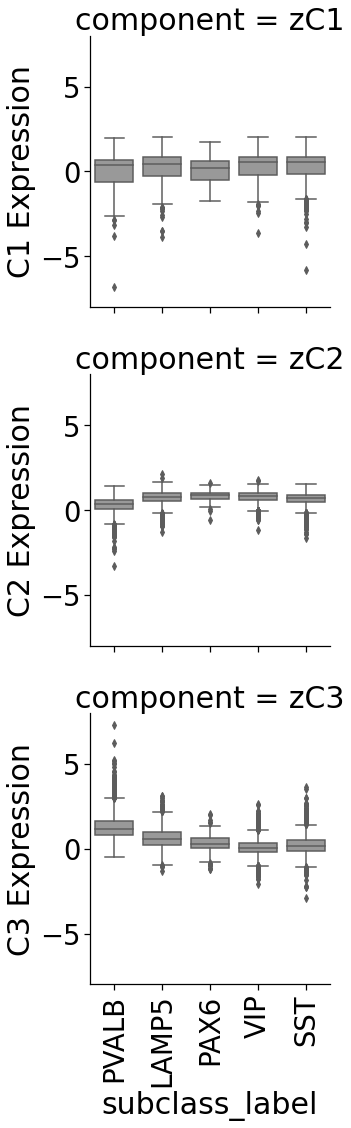

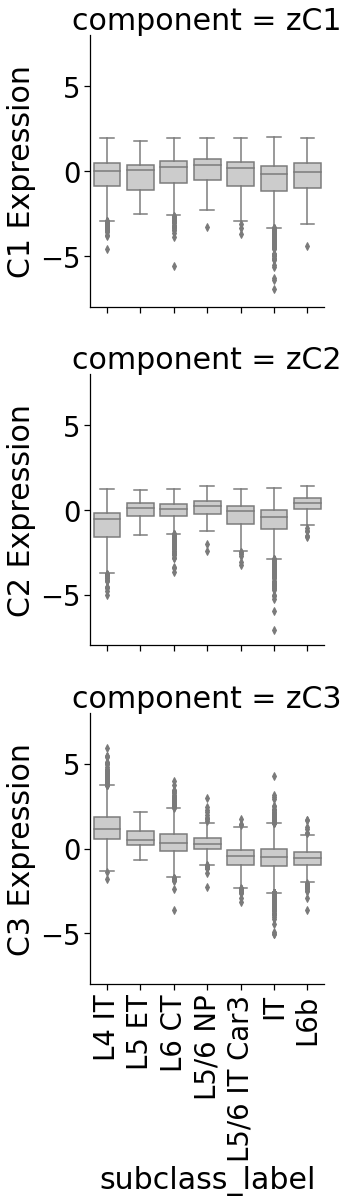

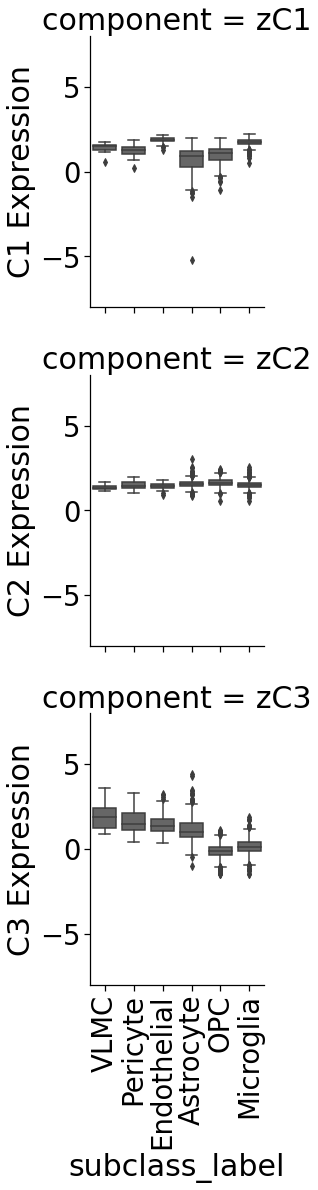

In [46]:
# preset label orders so they are consistent across component / cell class
# and other decorations

sns.set_context('notebook',2.5)
pal = sns.color_palette('binary',4)
orders = {'GABAergic': ['PVALB','LAMP5','PAX6','VIP','SST'],
         'Glutamatergic':['L4 IT','L5 ET','L6 CT','L5/6 NP',
                           'L5/6 IT Car3','IT','L6b'],
         'Non-neuronal': ['VLMC','Pericyte','Endothelial',
                         'Astrocyte','OPC','Microglia']
        }
colors = {'GABAergic':pal[1],'Glutamatergic': pal[0],'Non-neuronal':pal[2]}

# for each cell class
for cl in tall.class_label.unique()[1:]:
    # plot component expression of each component across subclass
    g = sns.catplot(x='subclass_label',y='expr',row='component',kind='box',
                data=tall[tall.class_label==cl], order=orders[cl],color=colors[cl])
    g.set_xticklabels(rotation=90)
    # decorate and save
    for i in range(3):
        g.axes[i][0].set_ylim(-8,8)
        g.axes[i][0].set_ylabel('C%s Expression'%(i+1))
    #plt.savefig(os.path.join(figdir,'CellTypes_%s.pdf'%cl),bbox_inches = 'tight')
    plt.show()

Scrolling through, we can see that there is a high degree of variation of C3 expression _within_ all three cell classes, especially compared to the other two components. This is fascinating considering there was comparably quite little variation in C3 express _between_ cell class. 

# Dev Single Cell

In [71]:
rdata = pyreadr.read_r('/Users/jacobv/Science/PLS_GXP/CellsnLayers/DevCells/Sestan.fetalHuman.Psychencode.Rdata')

In [72]:
rdata.keys()

odict_keys(['count2', 'cpm2', 'meta2'])

In [73]:
devmeta = rdata['meta2']

In [74]:
devmtx = rdata['cpm2']

In [75]:
devmtx.loc[:,'gene_symbol'] = [x.split('|')[1] for x in devmtx.index]

In [76]:
dups = []
dind = []
catch = []
for i,row in devmtx.iterrows():
    x = row['gene_symbol']
    if x in catch: 
        dups.append(x)
        dind.append(i)
    else:
        catch.append(x)
        
#devmtx = devmtx.drop(dind)

In [77]:
devmtx = devmtx.drop(dind)
devmtx.shape

(57996, 763)

In [78]:
devmtx.index = devmtx.gene_symbol.values
devmtx.drop('gene_symbol',axis=1,inplace=True)

In [79]:
devshared = set(comps.index) & set(devmtx.index)

In [80]:
len(devshared)

14524

In [123]:
devmtx.loc[devshared].shape

(14524, 762)

In [81]:
devmtx = devmtx.loc[devshared]

In [82]:
#cells = pandas.DataFrame(index = mtx.index)
devcells = pandas.DataFrame(index=devmeta.index)
for i in range(1,4):
    print('working on component',i)
    #cells.loc[:,'C%s'%i] = np.dot(mtx.values,comps['C%s_expr'%i].values)
    devcells.loc[:,'C%s'%i] = np.dot(devmtx.loc[devshared].T,comps.loc[devshared,'C%s_expr'%i].values)

working on component 1
working on component 2
working on component 3


In [83]:
for col in devmeta.columns:
    devcells.loc[:,col] = devmeta[col].values

In [84]:
for i,row in devcells.iterrows():
    ctype = row['ctype']
    if 'Ex' in ctype:
        devcells.loc[i,'cclass'] = 'Glutamatergic'
    elif 'In' in ctype:
        devcells.loc[i,'cclass'] = 'GABAergic'
    elif 'Nas' in ctype:
        devcells.loc[i,'cclass'] = 'Nas'
    elif 'NEPRGC' in ctype:
        devcells.loc[i,'cclass'] = 'NEPRGC'
    else:
        devcells.loc[i,'cclass'] = 'Non-neuronal'

In [88]:
devcells.ctype.value_counts().sort_index()

Astro         49
Endo          29
ExN1          81
ExN2          10
ExN3          18
IPC1         143
IPC2          27
InN1          18
InN2          21
Microglia     11
NEPRGC1       57
NEPRGC2       31
NEPRGC3       16
NEPRGC4       20
NasN1         85
NasN2         23
NasN3         23
NasN4         14
NasN5         11
NasN6         15
OPC1          13
OPC2          20
Oligo         10
Pericyte      17
Name: ctype, dtype: int64

In [91]:
for i,row in devcells.iterrows():
    devcells.loc[i,'ctype_2'] = ['%s_%s'%(row['cclass'],row['ctype'])]

In [123]:
from sklearn.preprocessing import StandardScaler
for col in ['C1','C2','C3']:
    devcells.loc[:,'z%s'%col] = StandardScaler().fit_transform(devcells[col].values.reshape(-1,1))[:,0]

component 1


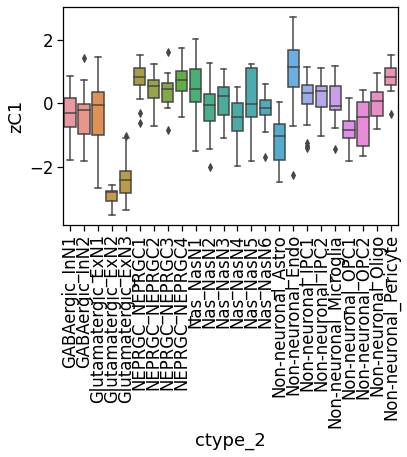

component 2


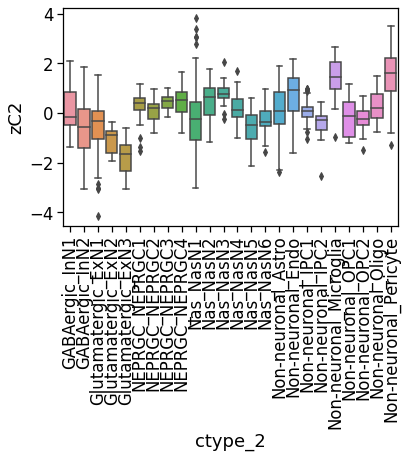

component 3


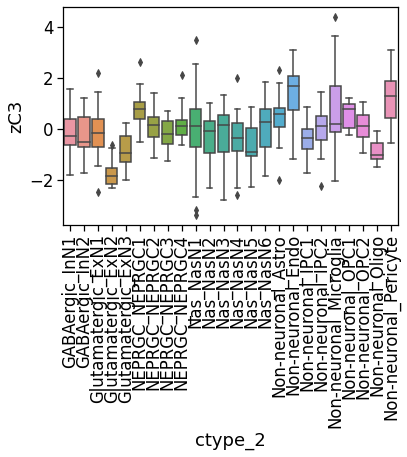

In [125]:
for i in range(1,4):
    print('component',i)
    g=sns.boxplot(x='ctype_2',y='zC%s'%i,data=devcells,
                 order=sorted(devcells.ctype_2.unique()))
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    plt.show()

In [236]:
devcells.loc[:,'ind'] = range(len(devcells))
devtall = devcells.melt(id_vars='ind',value_vars=['zC1','zC2','zC3'], var_name='component',value_name='expr')
devtall.loc[:,'cclass'] = devcells.cclass.tolist() * 3
devtall.loc[:,'AgePCW'] = [int(x.split('P')[0]) for x in devcells.Age] * 3

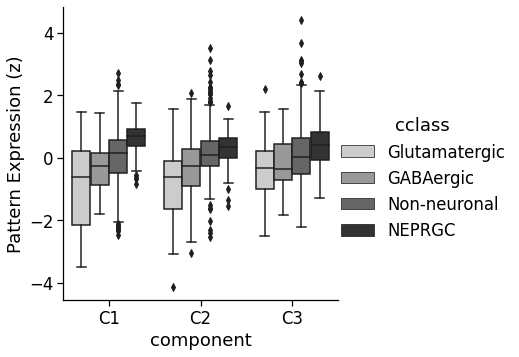

In [155]:
sns.set_context('notebook',font_scale=1.5)
g=sns.catplot(x='component',y='expr',hue='cclass',data=devtall,kind='box',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal','NEPRGC'],
             palette='binary')
g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/DEVcellclass.pdf',
           bbox_inches='tight')

component 1


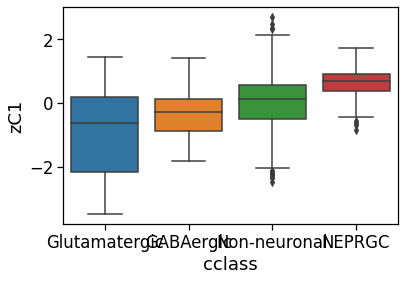

component 2


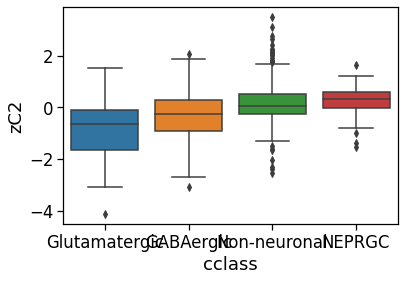

component 3


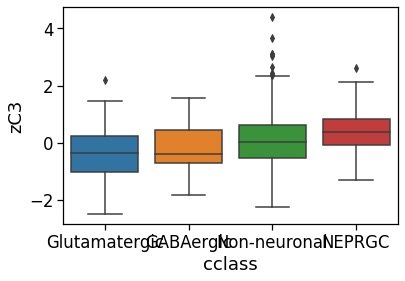

In [126]:
for i in range(1,4):
    print('component',i)
    sns.boxplot(x='cclass',y='zC%s'%i,data=devcells,
               order=['Glutamatergic','GABAergic','Non-neuronal','NEPRGC'])
    plt.show()

component 1


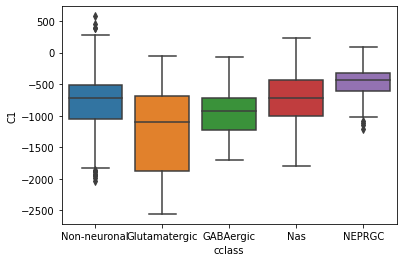

component 2


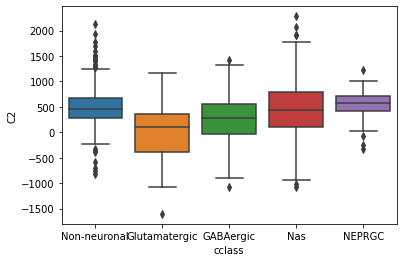

component 3


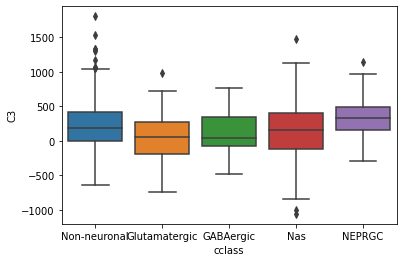

In [142]:
for i in range(1,4):
    print('component',i)
    sns.boxplot(x='cclass',y='C%s'%i,data=devcells)
    plt.show()

In [140]:
lr = LogisticRegressionCV(random_state=123,)
y = devcells[devcells.isin(['Glutamatergic','GABAergic','Non-neuronal'])]['cclass'].dropna()
X = devcells.loc[y.index,['zC1','zC2','zC3']]
pred = cross_val_predict(lr,X,y,groups=y)

print(classification_report(y,pred))
print('accuracy:', accuracy_score(y,pred))
print('balanced accuracy:',balanced_accuracy_score(y,pred))


               precision    recall  f1-score   support

    GABAergic       0.00      0.00      0.00        39
Glutamatergic       0.62      0.39      0.47       109
 Non-neuronal       0.75      0.94      0.84       319

     accuracy                           0.73       467
    macro avg       0.46      0.44      0.44       467
 weighted avg       0.66      0.73      0.68       467

accuracy: 0.7323340471092077
balanced accuracy: 0.44191999079692845


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [231]:
devcells.Age.value_counts()

8PCW     205
19PCW    196
6PCW     119
16PCW    115
5PCW      74
20PCW     53
Name: Age, dtype: int64

In [243]:
devcells.cclass.value_counts()

Non-neuronal     319
Nas              171
NEPRGC           124
Glutamatergic    109
GABAergic         39
Name: cclass, dtype: int64

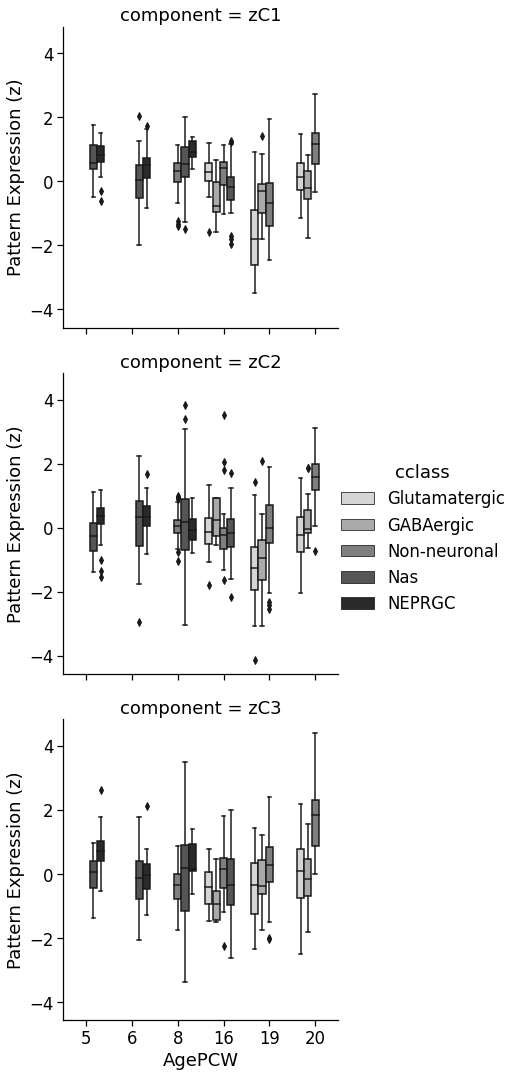

In [240]:
sns.set_context('notebook',font_scale=1.5)
g=sns.catplot(x='AgePCW',y='expr',hue='cclass',data=devtall,kind='box',row='component',
            hue_order=['Glutamatergic','GABAergic','Non-neuronal','Nas','NEPRGC'],
             palette='binary')
#g.set_xticklabels(['C1','C2','C3'])
g.set_ylabels('Pattern Expression (z)')
# plt.savefig('/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/SubFigs/DEVcellclass.pdf',
#            bbox_inches='tight')